## Ensemble Learning

#### Building a classification model with the default of credit card clients data. Info On Dataset: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

1) First tuning a decision tree classifier tuning one parameter at a time using gridsearch, then running all parameters using a randomized search.

2) Next, tuning different classifiers which include:
Random forest classfier
Adaboost Tree classifier
Extra trees classifier
Gradient Boosted Tree classifier
Logistic Regression

3) Creating a voting classifier

4) Analyzing and comparing the results

In [1]:
import numpy as np
import pandas as pd

#Making this notebook's output stable across runs
np.random.seed(123)

# plot nice figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

## Preparing Data

In [3]:
df = pd.read_excel("C:/Users/willjdsouza/Desktop/github/default of credit card clients.xls", 
                   sheet = 0, skiprows= 1, header = 0)

In [4]:
#splitting data into train and test

from sklearn.model_selection import train_test_split
X = df[['LIMIT_BAL','SEX', 'EDUCATION', 'MARRIAGE', 'AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
        'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]
y = df['default payment next month']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.15, random_state=42)

In [6]:
# Setting target value == 1

y_train_1 = (y_train == 1)
y_test_1 = (y_test == 1)

In [7]:
# pipeline for data 

x_train_num = X_train[['LIMIT_BAL', 'AGE','BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
        'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT5']]

cat_attribs = X_train[['SEX', 'EDUCATION', 'MARRIAGE', 'AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']]

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

num_attribs = list(x_train_num)
cat_attribs = list(cat_attribs)
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ]) 

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
])
credit_prepared = full_pipeline.fit_transform(X_train)

C:\Users\willjdsouza\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Tuning Decision Tree One Parameter at a Time


{'criterion': 'gini'} 0.392033036862
{'criterion': 'entropy'} 0.403618063874


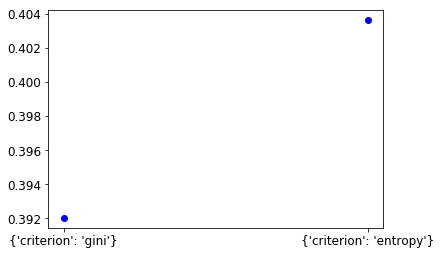

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'criterion': ['gini', 'entropy']}
  ]

dtc = DecisionTreeClassifier()
grid_search = GridSearchCV(dtc, param_grid,
scoring='precision')
grid_search.fit(credit_prepared, y_train_1)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(params, mean_score)
    
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    plt.plot(params, mean_score, 'bo')

### Max Depth

{'max_depth': None} 0.391913138101
{'max_depth': 1} 0.69239906206
{'max_depth': 3} 0.70666928044
{'max_depth': 5} 0.687100333241
{'max_depth': 7} 0.657351137603
{'max_depth': 10} 0.610966536966


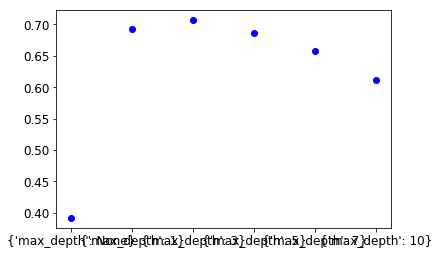

In [9]:
param_grid = [
    {'max_depth': [None, 1, 3, 5, 7, 10]}
  ]


grid_search = GridSearchCV(dtc, param_grid,
scoring='precision')
grid_search.fit(credit_prepared, y_train_1)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(params, mean_score)

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    plt.plot(params, mean_score, 'bo')

### Min Samples Split

{'min_samples_split': 2} 0.390957457087
{'min_samples_split': 4} 0.402461402813
{'min_samples_split': 6} 0.404599456757
{'min_samples_split': 8} 0.407799050715
{'min_samples_split': 10} 0.416899542227


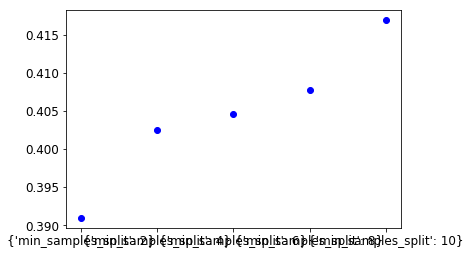

In [10]:
param_grid = [
    {'min_samples_split': [2, 4, 6, 8, 10]}
  ]

dtc = DecisionTreeClassifier()
grid_search = GridSearchCV(dtc, param_grid,
scoring='precision')
grid_search.fit(credit_prepared, y_train_1)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(params, mean_score)
    
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    plt.plot(params, mean_score, 'bo')

### Min Samples Leaf

{'min_samples_leaf': 1} 0.38967703097
{'min_samples_leaf': 3} 0.417771435347
{'min_samples_leaf': 5} 0.436786262464
{'min_samples_leaf': 7} 0.46439510416
{'min_samples_leaf': 10} 0.488731009473


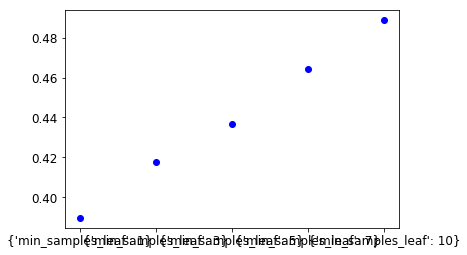

In [11]:
param_grid = [
    {'min_samples_leaf': [1, 3, 5, 7, 10]}
  ]

dtc = DecisionTreeClassifier()
grid_search = GridSearchCV(dtc, param_grid,
scoring='precision')
grid_search.fit(credit_prepared, y_train_1)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(params, mean_score)
    
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    plt.plot(params, mean_score, 'bo')

### Max Leaf Nodes

{'max_leaf_nodes': None} 0.391880209741
{'max_leaf_nodes': 2} 0.69239906206
{'max_leaf_nodes': 4} 0.691329429818
{'max_leaf_nodes': 6} 0.693907158124
{'max_leaf_nodes': 8} 0.696252038736
{'max_leaf_nodes': 10} 0.694172889111


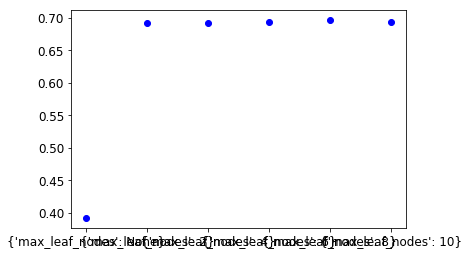

In [12]:
param_grid = [
    {'max_leaf_nodes': [None, 2, 4, 6, 8, 10]}
  ]

dtc = DecisionTreeClassifier()
grid_search = GridSearchCV(dtc, param_grid,
scoring='precision')
grid_search.fit(credit_prepared, y_train_1)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(params, mean_score
         )
    
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    plt.plot(params, mean_score, 'bo')   

## Randomized Search on all Parameters at Once

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_distribs = { 'criterion' : ['gini', 'entropy'], 'max_depth': randint(3,5),
     'min_samples_split': randint(2, 10), 'min_samples_leaf': randint(1, 10), 'max_leaf_nodes' : randint(8, 16) 
    }

rnd_search = RandomizedSearchCV(DecisionTreeClassifier(), param_distribs, scoring ='precision', n_iter=10, cv=3, n_jobs = -1)
rnd_search.fit(credit_prepared, y_train_1)

print("Best Score:", rnd_search.best_score_)
print("Best Params:", rnd_search.best_params_)


from sklearn.metrics import accuracy_score

y_pred_rnd = rnd_search.predict(credit_prepared)

print("Accuracy Score:", accuracy_score(y_train_1, y_pred_rnd))

Best Score: 0.692064876773
Best Params: {'criterion': 'entropy', 'max_depth': 4, 'max_leaf_nodes': 8, 'min_samples_leaf': 7, 'min_samples_split': 3}
Accuracy Score: 0.818546712803


## Ensemble Learning

### Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

param_distribs = {'n_estimators': randint(10,1000), 'max_depth': randint(1, 10), 
                  'min_samples_split': randint(2, 10), 'min_samples_leaf': randint(1,10),
                  'max_leaf_nodes' : randint(2,10)}

rnd_search_rfc = RandomizedSearchCV(RandomForestClassifier(), param_distribs, scoring ='precision', n_iter=10, cv=3, n_jobs = -1)
rnd_search_rfc.fit(credit_prepared, y_train_1)

print("RFC Best Score:", rnd_search_rfc.best_score_)

y_pred_rfc = rnd_search_rfc.predict(credit_prepared)
print("RFC Accuracy:", accuracy_score(y_train_1, y_pred_rfc))

RFC Best Score: 0.770525400269
RFC Accuracy: 0.792525951557


### Adaboost Tree Classifier

In [15]:
from sklearn.ensemble import AdaBoostClassifier
param_distribs = {'learning_rate': uniform(0.0, 5.0), 'n_estimators' : randint(10,50)}

rnd_search_ada = RandomizedSearchCV(AdaBoostClassifier(DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, 
                max_leaf_nodes = 8, min_samples_leaf = 7, min_samples_split = 3)), 
                param_distribs, scoring ='precision', n_iter=10, cv=3, n_jobs = -1)
rnd_search_ada.fit(credit_prepared, y_train_1)

print("ADA Best Score:", rnd_search_ada.best_score_)

y_pred_ada = rnd_search_ada.predict(credit_prepared)
print("ADA Accuracy:", accuracy_score(y_train_1, y_pred_ada))

ADA Best Score: 0.696168570412
ADA Accuracy: 0.818546712803


### Extra Trees Classifier

In [16]:
from sklearn.ensemble import ExtraTreesClassifier

param_distribs = {'n_estimators': randint(10,1000), 'max_depth': randint(1, 10), 
                  'min_samples_split': randint(2, 10), 'min_samples_leaf': randint(1,10),
                  'max_leaf_nodes' : randint(2,10)}

rnd_search_etc = RandomizedSearchCV(ExtraTreesClassifier(), param_distribs, scoring ='precision', n_iter=10, cv=3, n_jobs = -1)
rnd_search_etc.fit(credit_prepared, y_train_1)

print("ETC Best Score:", rnd_search_etc.best_score_)

y_pred_etc = rnd_search_etc.predict(credit_prepared)
print("ETC Accuracy:", accuracy_score(y_train_1, y_pred_etc))

ETC Best Score: 0.768000045085
ETC Accuracy: 0.791418685121


### Gradient Boosted Tree Classifier

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

param_distribs = {'learning_rate': uniform(0.1, 1.0), 'n_estimators' : randint(100, 500),
                  'max_depth': randint(3, 10), 'min_samples_split': randint(2, 10), 'min_samples_leaf': randint(1,10),
                  'max_leaf_nodes' : randint(2,10)}

rnd_search_gbc = RandomizedSearchCV(GradientBoostingClassifier(), param_distribs, scoring ='precision', n_iter=10, cv=3, n_jobs = -1)
rnd_search_gbc.fit(credit_prepared, y_train_1)

print("GBC Best Score:", rnd_search_gbc.best_score_)

y_pred_gbc = rnd_search_gbc.predict(credit_prepared)
print("GBC Accuracy:", accuracy_score(y_train_1, y_pred_gbc))

GBC Best Score: 0.685394575139
GBC Accuracy: 0.82214532872


### Logisitic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

param_distribs = { "penalty" : ['l1', 'l2'], 'C': uniform(0.1, 10)}

rnd_search_logr = RandomizedSearchCV(LogisticRegression(penalty= 'l1'), param_distribs, scoring ='precision', n_iter=10, cv=3, n_jobs = -1)
rnd_search_logr.fit(credit_prepared, y_train_1)

print("Logisitic Regression Best Score:", rnd_search_logr.best_score_)
      
y_pred_logr = rnd_search_logr.predict(credit_prepared)
print("Logisitic Regression Accuracy:", accuracy_score(y_train_1, y_pred_logr))


Logisitic Regression Best Score: 0.67932644204
Logisitic Regression Accuracy: 0.822237600923


### Voting Classifier based on above (hard & soft)

I was interested to see how these ensembles would work if I used a voting classifier. It  is not the best when the models are similar, and it should be used more when the models are different. However, I was just interested to see how it would do.

In [19]:
lr = rnd_search_logr.best_estimator_ 
gbc = rnd_search_gbc.best_estimator_  
etc = rnd_search_etc.best_estimator_
ada = rnd_search_ada.best_estimator_
rfc = rnd_search_rfc.best_estimator_

##### Hard Voting

In [20]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
estimators=[('lr', lr), ('gbc', gbc), ('etc', etc), ('ada', ada), ('rfc', rfc)],
voting='hard')

voting_clf.fit(credit_prepared, y_train_1)

for clf in (lr, gbc, etc, ada, rfc, voting_clf):
    clf.fit(credit_prepared, y_train_1)
    y_pred = clf.predict(credit_prepared)
    print(clf.__class__.__name__, accuracy_score(y_train_1, y_pred))

LogisticRegression 0.822237600923
GradientBoostingClassifier 0.82214532872
ExtraTreesClassifier 0.789757785467
AdaBoostClassifier 0.818546712803
RandomForestClassifier 0.792987312572
VotingClassifier 0.817900807382


##### Soft Voting

In [21]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
estimators=[('lr', lr), ('gbc', gbc), ('etc', etc), ('ada', ada), ('rfc', rfc)],
voting='soft')

voting_clf.fit(credit_prepared, y_train_1)

for clf in (lr, gbc, etc, ada, rfc, voting_clf):
    clf.fit(credit_prepared, y_train_1)
    y_pred = clf.predict(credit_prepared)
    print(clf.__class__.__name__, accuracy_score(y_train_1, y_pred))

LogisticRegression 0.822237600923
GradientBoostingClassifier 0.82214532872
ExtraTreesClassifier 0.790311418685
AdaBoostClassifier 0.818546712803
RandomForestClassifier 0.792572087659
VotingClassifier 0.814901960784


### Conclusions

The ensembles that I get the best score in order of precision are: Random Forest, Extra Trees, Gradient Boosting, Ada Booster and Logistic Regression 

The ensembles that I get the best accuracy in terms of predicitions are: Logisitic Regression, Gradient Boosting, Ada booster, Random Forest and Extra Trees.

If I was to judge this based on precision, Random Forest would be the best model, and if I was to judge it based on accuracy of predictions, Logisitic regression would win.

The hard voting pretty much the same result as the Ada booster, and logistic regression was still the strongest. The soft voting performed slightly worse.